In [1]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from utils import f1_score_function

## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskB_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,topic,conspiracy
0,0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon,1
1,1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid,0
2,2,L'avete capito che non toglieranno il green pa...,Covid,0
3,3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta,3
4,4,"In breve tempo, per accedere a Internet, sarà ...",Qanon,1


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            810 non-null    int64 
 1   comment_text  810 non-null    object
 2   topic         810 non-null    object
 3   conspiracy    810 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.4+ KB


0 is Covid-Conspiracy,

1 is Qanon-Conspiracy,

2 is Flat Earth-Conspiracy,

3 is Pro-Russia Conspiracy.

0    435
1    242
3     76
2     57
Name: conspiracy, dtype: int64


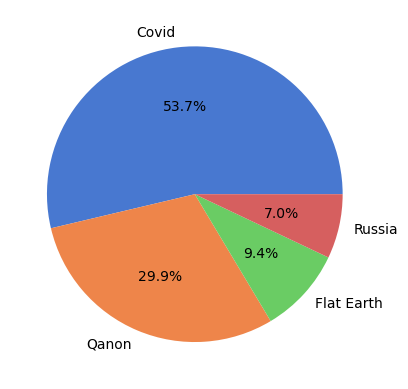

In [5]:
print(texts_df.conspiracy.value_counts())

palette = sns.color_palette('muted')
topic_labels = ['Covid', 'Qanon', 'Flat Earth', 'Russia']
plt.pie(texts_df.conspiracy.value_counts(), labels=topic_labels, autopct='%1.1f%%', colors=palette)
plt.show()

### Test set

In [6]:
texts_df_test = pd.read_csv('subtaskB_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,Ho fatto delle foto aeree ad una quota di circ...
1,1,Prof. Bellavite: tantissime persone costrette ...
2,2,"Ma si allontana.... su una terra PIATTA,......"
3,3,Non tutti gli Ukraini sono contro la Russia.\n...
4,4,Non opinioni ma dati.\n\nUno strepitoso **Giov...


In [7]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            300 non-null    int64 
 1   comment_text  300 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


## Preprocessing

In [8]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('all')

stop_words = set(stopwords.words('italian'))
stemmer = SnowballStemmer('italian')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/giacomo/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/giacomo/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/giacomo/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/giacomo/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/giacomo/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]

In [9]:
def preprocess(text):
    # Remove non-alphanumeric character
    text = re.sub(r"'", " ", text)
    text = re.sub(r"_", " ", text)
    text = re.sub(r'[^\w\s]', ' ', text) 

    # Tokenize
    word_list = text.split() 

    # Remove numbers
    word_list = [re.sub(r'\d+', '', word) for word in word_list]

    # Remove < 3 chars words
    word_list = [word for word in word_list if len(word) >= 3]
    
    # Remove stopwords
    word_list = [word for word in word_list if not word in stop_words]

    # Stemming
    word_list = [stemmer.stem(word) for word in word_list]

    # Remove stopwords
    word_list = [word for word in word_list if not word in stop_words]
    
    return ' '.join(word_list)

In [10]:
texts_df.comment_text = texts_df.comment_text.apply(preprocess)
texts_df_test.comment_text = texts_df_test.comment_text.apply(preprocess)
texts_df.head()

,Id,comment_text,topic,conspiracy
0,0,siam davant prov sol quozient intellett spirit...,Qanon,1
1,1,stor bimb bergam vaccin qusto giornal accenn n...,Covid,0
2,2,cap togl green pass anzi fint togl restrizion ...,Covid,0
3,3,quind fars spaz terr pallon continu fint viagg...,Terra Piatta,3
4,4,brev temp acced internet richiest document ide...,Qanon,1


## Train-Validation split

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [12]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiracy):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [13]:
print(train_df.info())
print(train_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 34 to 376
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            648 non-null    int64 
 1   comment_text  648 non-null    object
 2   topic         648 non-null    object
 3   conspiracy    648 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.3+ KB
None
0    348
1    193
3     61
2     46
Name: conspiracy, dtype: int64


In [14]:
print(val_df.info())
print(val_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 396 to 694
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            162 non-null    int64 
 1   comment_text  162 non-null    object
 2   topic         162 non-null    object
 3   conspiracy    162 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.3+ KB
None
0    87
1    49
3    15
2    11
Name: conspiracy, dtype: int64


In [15]:
labels_tr = train_df.conspiracy.values
labels_val = val_df.conspiracy.values

## Topic-specific tf-idf

In this section we try to identify the most specific set for each topic to classify. Basically we caclulate the avearage tf-idf for each word in respect to the documents of each topic. Then, after [0-100] normalization, we divide the average tf-idf for each word by the average tf-idf of the same word in the other topics. The result is a score that indicates how much the word is specific to the topic. The higher the score, the more specific the word is to the topic.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# Gets the average tfidf score for each word in the corpus
def get_avg_tfidf_df(texts_df):
    tfidf = TfidfVectorizer(strip_accents='unicode')
    # Rows are comments, columns are words
    tfidf_vectors = tfidf.fit_transform(texts_df.comment_text)
    num_comments = tfidf_vectors.shape[0]

    words = tfidf.get_feature_names_out()

    # Average tfidf score for each word
    avg_tfidf = np.sum(tfidf_vectors, axis=0)/num_comments
    avg_tfidf = np.array(avg_tfidf).reshape(-1)

    # Create dataframe with first column avg_tfidf and second column words
    avg_tfidf_df = pd.DataFrame(data = {'words': words, 'avg_tfidf': avg_tfidf})
    # Order by avg_tfidf
    #avg_tfidf_df = tfidf_df.sort_values(by='avg_tfidf', ascending=False)

    return avg_tfidf_df

In [18]:
def get_topic_specific_tfidf(texts_df):
    # Divide texts_df in multiple dataframes, one for each conspiracy topic
    topic_texts_df_list = []
    for conspiracy in texts_df.conspiracy.unique():
        topic_texts_df_list.append(texts_df[texts_df.conspiracy == conspiracy])
    
    # Get tfidf for each topic
    topic_avg_tfidf_df_list = []
    for topic_texts_df in topic_texts_df_list:
        topic_avg_tfidf_df_list.append(get_avg_tfidf_df(topic_texts_df))

    # Join all the dataframes based on the words column
    topic_tfidf_df = topic_avg_tfidf_df_list[0].merge(topic_avg_tfidf_df_list[1], on='words', how='outer', suffixes=('_covid', '_qanon'))
    topic_tfidf_df = topic_tfidf_df.merge(topic_avg_tfidf_df_list[2], on='words', how='outer')
    topic_tfidf_df = topic_tfidf_df.merge(topic_avg_tfidf_df_list[3], on='words', how='outer', suffixes=('', '_flat_earth'))
    topic_tfidf_df = topic_tfidf_df.rename(columns={'avg_tfidf': 'avg_tfidf_russia'})
    topic_tfidf_df = topic_tfidf_df.fillna(0)

    # Normalize the tfidf values to 0-100
    for col in topic_tfidf_df.columns:
        if col.startswith('avg_tfidf_'):
            topic_tfidf_df[col] = topic_tfidf_df[col] * 100 / topic_tfidf_df[col].max()

    # For each column (topic) divide it by the sum of the other columns + 1
    for col in topic_tfidf_df.columns[1:]:
        other_cols = [c for c in topic_tfidf_df.columns if c != col]
        topic_tfidf_df[col] = topic_tfidf_df[col] / (topic_tfidf_df[other_cols].sum(axis=1) + 1)

    return topic_tfidf_df

Apply the method to the train set

In [21]:
tr_topic_tfidf = get_topic_specific_tfidf(train_df)
pd.set_option('display.expand_frame_repr', False)


# Print the vals for each topic in descending order
for col in tr_topic_tfidf.columns[1:]:

    print(col)
    print(tr_topic_tfidf.sort_values(by=col, ascending=False).head(40))
    print()

avg_tfidf_covid
            words  avg_tfidf_covid  avg_tfidf_qanon  avg_tfidf_russia  avg_tfidf_flat_earth
992           dos        23.939568         0.000000               0.0                   0.0
316        avvers        15.754102         0.000000               0.0                   0.0
1602       inocul        15.027083         0.000000               0.0                   0.0
1967         mrna        14.798967         0.000000               0.0                   0.0
1372       giovan        14.456688         0.000000               0.0                   0.0
1039      efficac        13.687523         0.000000               0.0                   0.0
1195       farmac        13.044677         0.000000               0.0                   0.0
2055   obbligator        12.993569         0.000000               0.0                   0.0
2964  sperimental        11.597360         0.000000               0.0                   0.0
1832    mascherin        11.391805         0.000000             

/tmp/ipykernel_6244/2213608397.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  topic_tfidf_df[col] = topic_tfidf_df[col] / (topic_tfidf_df[other_cols].sum(axis=1) + 1)
/tmp/ipykernel_6244/2213608397.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  topic_tfidf_df[col] = topic_tfidf_df[col] / (topic_tfidf_df[other_cols].sum(axis=1) + 1)
/tmp/ipykernel_6244/2213608397.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  topic_tfidf_df[col] = topic_tfidf_df[col] / (topic_tfidf_df[

### Wrappper object for classification on training and evaluation

At training time, we select only the top-K words for each topic, then we count the occurrencies of these words in each sample and we use them as features for a classifier.

In [50]:
class TopicSpecificTfidfClf():
    def __init__(self, topic_tfidf_df, classifier_tr_func, k=20):
        self.classifier_tr_func = classifier_tr_func
        # Save the top k words for each topic
        self.topic_words = []
        for col in topic_tfidf_df.columns[1:]:
            # Select the top k words for each topic
            self.topic_words += topic_tfidf_df.sort_values(by=col, ascending=False).head(k).words.values.tolist()

    def train(self, texts, labels):
        # Rows are texts (samples), columns are topic words (features)
        words_occ = np.zeros((len(texts), len(self.topic_words)))

        # For each text, count the occurrencies of the saved topic words
        for i, text in enumerate(texts):
            for word in text.split():
                for j, topic_words in enumerate(self.topic_words):
                    if word in topic_words:
                        words_occ[i, j] += 1

        # Train a simple classifier on the extracted features        
        preds, self.classifier = self.classifier_tr_func(words_occ, labels)
        return preds


    def predict(self, texts):
        # Rows are texts (samples), columns are topic words (features)
        words_occ = np.zeros((len(texts), len(self.topic_words)))

        # For each text, count the occurrencies of the saved topic words
        for i, text in enumerate(texts):
            for word in text.split():
                for j, topic_words in enumerate(self.topic_words):
                    if word in topic_words:
                        words_occ[i, j] += 1
            
        # Predict using the classifier
        preds = self.classifier.predict(words_occ)
        return preds
    

## Train

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

## Train-Validation split

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [53]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiracy):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [54]:
print(train_df.info())
print(train_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 34 to 376
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            648 non-null    int64 
 1   comment_text  648 non-null    object
 2   topic         648 non-null    object
 3   conspiracy    648 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.3+ KB
None
0    348
1    193
3     61
2     46
Name: conspiracy, dtype: int64


In [55]:
print(val_df.info())
print(val_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 396 to 694
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            162 non-null    int64 
 1   comment_text  162 non-null    object
 2   topic         162 non-null    object
 3   conspiracy    162 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.3+ KB
None
0    87
1    49
3    15
2    11
Name: conspiracy, dtype: int64


Use Random Forest with internal CV to find the best hyperparameters, with final refit on the training set.

In [56]:
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_random_forest(X, y, cv=6, print_res=True):
    params = [{
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [64, 128, 256]
    }] 
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
    clf.fit(X, y)
    if print_res:
        print("RF - Best parameters set found:")
        print(clf.best_params_)
    
    preds = clf.predict(X)
    
    return preds, clf

Initialization, training and eval for different values of K (number of top words to select for each topic)

In [57]:
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
val_f1_list = []
val_acc_list = []

In [58]:
for k in k_list:
    # Initialize
    topic_tfidf_clf = TopicSpecificTfidfClf(tr_topic_tfidf, build_random_forest, k=k)
    # Train
    preds_tr = topic_tfidf_clf.train(train_df.comment_text, labels_tr)
    # Evaluate
    preds_val = topic_tfidf_clf.predict(val_df.comment_text)

    acc_val = accuracy_score(labels_val, preds_val)
    f1_val = f1_score_function(labels_val, preds_val)
    val_acc_list.append(acc_val)
    val_f1_list.append(f1_val)

    print( 'VALIDATION RESULTS FOR K =', k)
    print(classification_report(labels_val, preds_val))

RF - Best parameters set found:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 128}
VALIDATION RESULTS FOR K = 10
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        87
           1       0.67      0.24      0.36        49
           2       0.57      0.73      0.64        11
           3       0.89      0.53      0.67        15

    accuracy                           0.67       162
   macro avg       0.70      0.61      0.61       162
weighted avg       0.68      0.67      0.63       162

RF - Best parameters set found:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 256}
VALIDATION RESULTS FOR K = 20
              precision    recall  f1-score   support

           0       0.71      0.90      0.79        87
           1       0.67      0.41      0.51        49
           2       0.62      0.73      0.67        11
           3       0.89      0.53      0.67     

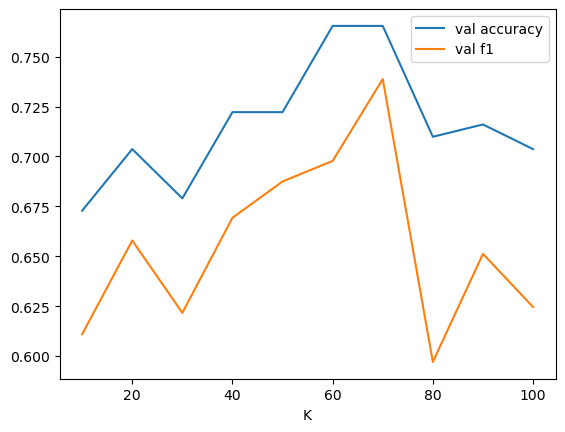

In [61]:
plt.plot(k_list, val_acc_list, label='val accuracy')
plt.plot(k_list, val_f1_list, label='val f1')
plt.xlabel('K')
plt.legend()
plt.show()

Best K is **K = 70**

## Retrain on the whole training set with the found K

Development set = training set + validation set

In [91]:
devel_df = texts_df.copy()
labels_devel = devel_df.conspiracy.values

In [92]:
# Get topic-specific tfidf for the development set
devel_topic_tfidf = get_topic_specific_tfidf(devel_df)

# Instantiate the classifier object with the best k (70)
topic_tfidf_clf = TopicSpecificTfidfClf(devel_topic_tfidf, build_random_forest, k=70)
# Train
preds_devel = topic_tfidf_clf.train(devel_df.comment_text, labels_devel)

print(classification_report(labels_devel, preds_devel))

/tmp/ipykernel_71318/774049163.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  topic_tfidf_df[col] = topic_tfidf_df[col] / (topic_tfidf_df[other_cols].sum(axis=1) + 1)
/tmp/ipykernel_71318/774049163.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  topic_tfidf_df[col] = topic_tfidf_df[col] / (topic_tfidf_df[other_cols].sum(axis=1) + 1)
/tmp/ipykernel_71318/774049163.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  topic_tfidf_df[col] = topic_tfidf_df[col] / (topic_tfidf_df[

RF - Best parameters set found:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 256}
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       435
           1       0.80      0.82      0.81       242
           2       0.85      0.89      0.87        57
           3       0.93      0.72      0.81        76

    accuracy                           0.87       810
   macro avg       0.87      0.84      0.85       810
weighted avg       0.87      0.87      0.87       810



Predict on test set

In [93]:
preds_test = topic_tfidf_clf.predict(texts_df_test.comment_text)

In [94]:
id_list = [i for i in range(len(preds_test))]
df = pd.DataFrame({'Id': id_list, 'Expected': preds_test})
df.to_csv('final_topic_tfidf_submission_B.csv', index=False)

Check % of diff with final submission to the bert to estimate the range of the retrain test score

In [96]:
tfidf_submission = preds_test

bert_submission = pd.read_csv('final_bert_submission_B.csv')['Expected'].to_numpy()
perc_diff = np.sum(tfidf_submission != bert_submission)/len(bert_submission)

print('Percentual difference between tfidf and bert test submission: {}%'.format(perc_diff*100))   

Percentual difference between tfidf and bert test submission: 24.333333333333336%


**RESULTS FROM KAGGLE:**

-On the 50% available hidden test set it scores 0.7006  F1 macro averaged

-On the other 50% of the test set it scores 0.80349  F1 macro averaged

-On the whole test set it scores **0.752045** F1 macro averaged